### Data Wrangling File (2020-2023). The capabilities of this file are the following: 
* Read in data from the github repository in python
* Mapping column IDs with real column names from refrence files 
* Perform preliminary data cleaning steps (Converting columns to numeric, renaming '.', '-1', '-3' values to NA)

Note: This should work for 2020 - 2023 data. Issue with 2018-19 data 


Importing necessary packages 

In [96]:
#Importing necessary packages
import pandas as pd
import os 
import numpy as np
import warnings
warnings.simplefilter("ignore")

Loading in all raw data & REF files and the REF files by storing them into dictionaries (HELPER FUNCTION)

In [223]:
def load_data(directory, year):
    """
    Reads all CSV files in the specified directory into a dictionary (RAWDATA) 
    and loads all sheets from an Excel file into another dictionary (REF).
    
    Args:
        directory (str): The path to the directory containing the raw data files.
        year (int or str): The year to append to dictionary keys.
    
    Returns:
        tuple: (RAWDATA, REF)
    """
    
    # Change to the specified directory
    os.chdir(directory)

    # Store all raw CSV data in a dictionary with dynamic year
    csv_files = [f for f in os.listdir() if f.endswith('.csv')]
    RAWDATA = {file.split('.')[0].lower(): pd.read_csv(file) for file in csv_files}

    # Look for an Excel file (assuming there's only one Excel file in the directory)
    excel_files = [f for f in os.listdir() if f.endswith('.xlsx') or f.endswith('.xls')]
    
    REF = {}
    if excel_files:
        file_path = excel_files[0]  # Taking the first Excel file found
        sheetname_ref = pd.ExcelFile(file_path).sheet_names
        REF = {f"{sheet}_ref{year}": pd.read_excel(file_path, sheet_name=sheet) for sheet in sheetname_ref}

    # Return both dictionaries
    return RAWDATA, REF

Mapping the column ID names in the raw data with the actual column names in the REF file (HELPER FUNCTION)

In [224]:
def rename_columns_using_ref(rawdata, ref):
    """
    Renames columns in each DataFrame in rawdata using the corresponding mapping found in ref.

    Args:
        rawdata (dict): Dictionary containing raw DataFrames with keys as filenames.
        ref (dict): Dictionary containing reference DataFrames with keys as filenames.

    Returns:
        dict: Dictionary containing renamed DataFrames.
    """
    
    updated_data = {}  # Dictionary to store updated DataFrames

    for raw_key, raw_df in rawdata.items():
        # Extract base name before the first underscore (_)
        base_name = raw_key.split("_")[0]
        
        # Find the matching key in REF (case-insensitive)
        matching_key = next((key for key in ref if key.lower().startswith(base_name.lower())), None)
        
        if matching_key:
            # Extract mapping from REF (second column = column ID, third column = actual column name)
            ref_df = ref[matching_key]
            column_mapping = dict(zip(ref_df.iloc[:, 1], ref_df.iloc[:, 2]))  # Map column ID → Actual name
            
            # Rename columns in RAWDATA DataFrame
            renamed_df = raw_df.rename(columns=column_mapping)
            
            # Store in updated_data with the original key
            updated_data[raw_key] = renamed_df

    # Print confirmation
    print(f"Renamed and stored {len(updated_data)} DataFrames.")

    return updated_data

# Example Usage:
data_23 = rename_columns_using_ref(rawdata_23, ref_23)


Renamed and stored 5 DataFrames.


Primary Data Cleaning (Helper Function)
* Converts all values (except district ID) to numeric  values
* Remove NA values which are encoded as either '.', -1, or -3
* Remove values that are supposed to be percent or rates that are > 100 

In [225]:
def primary_data_cleaning(df_dict):
    """
    Converts all columns in each DataFrame (except 'District Numer') to numeric.
    Replaces '.' and '-1' values with NaN.
    Drops columns containing 'rate' or 'percent' in their name if any values exceed 100,
    except for DataFrames with 'ref' in their title.
    
    Args:
        df_dict (dict): Dictionary of pandas DataFrames.
    
    Returns:
        dict: Dictionary of DataFrames with processed data.
    """
    processed_dict = {}
    
    for key, df in df_dict.items():
        # Skip processing for DataFrames whose key contains 'ref'
        if 'ref' in key.lower():
            processed_dict[key] = df.copy()
            continue
        
        df = df.copy()
        
        # Convert all columns except 'District Numer' to numeric
        print(f"{df.shape}: proccessed")
        for col in df.columns:
            if col != 'District Number':
                df[col] = df[col].replace({'.': np.nan, '-1': np.nan, '-3': np.nan})  # Replace invalid values with NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric
        
        # Identify columns that contain 'percent' or 'rate' in their name
        percent_rate_columns = [col for col in df.columns if 'percent' in col.lower() or 'rate' in col.lower()]
        
        # Drop columns if any value exceeds 100
        for col in percent_rate_columns:
            if df[col].max(skipna=True) > 100:
                df.drop(columns=[col], inplace=True)
        
        # Store the processed DataFrame
        processed_dict[key] = df
    
    #return processed_dict


In [226]:
def processing(directory, year):
    rawdata, ref = load_data(directory, year)
    updated_data = rename_columns_using_ref(rawdata, ref)
    return(updated_data)
    #final = primary_data_cleaning(updated_data)
    #return final
data20 = processing(r'C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\Data_Scraping\Raw Data\raw_data2020',
           2020)

Renamed and stored 5 DataFrames.


In [217]:
def primary_data_cleaning2(df_dict):
    """
    Converts all columns in each DataFrame (except 'District Number') to numeric.
    Replaces '.', '-1', and '-3' values with NaN.
    Drops columns containing 'rate' or 'percent' in their name if any values exceed 100,
    except for DataFrames with 'ref' in their title.
    
    Args:
        df_dict (dict): Dictionary of pandas DataFrames.
    
    Returns:
        dict: Dictionary of DataFrames with processed data.
    """
    processed_dict = {}

    for key, df in df_dict.items():
        # Skip processing for DataFrames whose key contains 'ref'
        if 'ref' in key.lower():
            processed_dict[key] = df.copy()
            continue
        
        df = df.copy()

        # Standardize column names by stripping spaces
        df.columns = df.columns.str.strip()

        # Identify the correct column name for "District Number" (case and space insensitive)
        district_col = next((col for col in df.columns if col.replace(" ", "").lower() == "districtnumber"), None)
        print(f"Identified 'District Number' column as: {district_col}")  # Debugging

        # Convert all columns except the identified 'District Number' to numeric
        print(f"{df.shape}: processed")
        for col in df.columns:
            if col != district_col:  # Use the identified column instead of hardcoded "District Number"
                df[col] = df[col].replace({'.': np.nan, '-1': np.nan, '-3': np.nan})  # Replace invalid values with NaN
                df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric

        # Identify columns that contain 'percent' or 'rate' in their name
        percent_rate_columns = [col for col in df.columns if 'percent' in col.lower() or 'rate' in col.lower()]

        # Drop columns if any value exceeds 100
        for col in percent_rate_columns:
            if df[col].max(skipna=True) > 100:
                df.drop(columns=[col], inplace=True)

        # Store the processed DataFrame
        processed_dict[key] = df

    return processed_dict

primary_data_cleaning2(data20)


Identified 'District Number' column as: District Number
(1202, 869): processed
Identified 'District Number' column as: District Number
(1202, 4169): processed


TypeError: arg must be a list, tuple, 1-d array, or Series

In [228]:
#data20['distprof_2020'].columns[39]
#for i, col in enumerate(data20['distprof_2020'].columns):
#    print(f"Column {i}: '{col}' (Length: {len(col)})")

hidden_chars = [ord(c) for c in data20['distprof_2020'].columns[39]]
print(f"Hidden Characters in Column Name: {hidden_chars}")

Hidden Characters in Column Name: [68, 105, 115, 116, 114, 105, 99, 116, 32, 78, 117, 109, 98, 101, 114]


In [229]:
import pandas as pd
import numpy as np

def primary_data_cleaning2(df_dict):
    """
    Cleans dataset column names, replaces special values with NaN, and converts numeric columns.
    """
    processed_dict = {}

    for key, df in df_dict.items():
        if 'ref' in key.lower():
            processed_dict[key] = df.copy()
            continue
        
        df = df.copy()
        
        # **Fix: Standardize column names (strip spaces, lowercase, remove special chars)**
        df.columns = df.columns.str.strip().str.replace('\xa0', '').str.lower()

        # Identify correct column for "District Number"
        district_col = next((col for col in df.columns if col.replace(" ", "").lower() == "districtnumber"), None)
        print(f"Identified 'District Number' column as: {district_col}")  # Debugging

        # Process all columns except 'District Number'
        for col in df.columns:
            if col != district_col:
                df[col] = df[col].astype(str).replace({'.': np.nan, '-1': np.nan, '-3': np.nan})
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Drop 'rate' and 'percent' columns with values over 100
        percent_rate_columns = [col for col in df.columns if 'percent' in col.lower() or 'rate' in col.lower()]
        for col in percent_rate_columns:
            if df[col].max(skipna=True) > 100:
                df.drop(columns=[col], inplace=True)

        processed_dict[key] = df

    return processed_dict

primary_data_cleaning2(data20)

Identified 'District Number' column as: district number
Identified 'District Number' column as: district number


TypeError: arg must be a list, tuple, 1-d array, or Series

Master data wrangling function (MAIN FUNCTION)
* Reads in data
* Maps column ids with real column names 
* Performs primary data cleaning

In [110]:
def master_data_processing(main_directory, output_directory):
    """
    Master function to load, rename, clean, and save data from multiple subdirectories.
    Processes only directories from 2020 and beyond.
    
    Args:
        main_directory (str): Path to the main directory containing multiple raw data folders.
        output_directory (str): Path to store cleaned data.
    """
    for folder in os.listdir(main_directory):
        folder_path = os.path.join(main_directory, folder)
        
        # Ensure the folder is a directory and follows the raw_dataYYYY format
        if os.path.isdir(folder_path) and folder.startswith("raw_data"):
            try:
                year = int(folder[-4:])  # Extract year from folder name
                if year < 2020:
                    continue  # Skip processing for years before 2020
                
                print(f"Processing data for year {year}...")
                
                # Load data excluding district_type files
                raw_data, ref_data = load_data(folder_path, year)
                raw_data = {key: df for key, df in raw_data.items() if 'district_type' not in key.lower()}
                ref_data = {key: df for key, df in ref_data.items() if 'district_type' not in key.lower()}
                
                # Rename columns using reference data
                renamed_data = rename_columns_using_ref(raw_data, ref_data)
                
                # Perform primary data cleaning
                cleaned_data = primary_data_cleaning(renamed_data)
                
                # Define output directory
                cleaned_dir = os.path.join(output_directory, f"cleaned_data{year}")
                os.makedirs(cleaned_dir, exist_ok=True)
                
                # Save cleaned data as CSV files
                for key, df in cleaned_data.items():
                    df.to_csv(os.path.join(cleaned_dir, f"{key}.csv"), index=False)
                
                print(f"Processed and saved cleaned data in: {cleaned_dir}")
            except ValueError:
                print(f"Skipping folder {folder}: Unable to determine year from folder name.")

master_data_processing(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\Data_Scraping\Raw Data",
                       r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\Data_Scraping\Clean Data")


Processing data for year 2020...
Renamed and stored 5 DataFrames.


TypeError: arg must be a list, tuple, 1-d array, or Series

In [ ]:
rawdata_21, ref_21 = load_data(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\Data_Scraping\Raw Data\raw_data2021", 2021)


In [121]:
rawdata_21, ref_21 = load_data(r"C:\Users\mmath\OneDrive\Desktop\Capstone\HERC_Sp25\Data_Scraping\Raw Data\raw_data2021", 2021)
data21 = rename_columns_using_ref(rawdata_21, ref_21)
primary_data_cleaning(data21)

Renamed and stored 5 DataFrames.


{'distgrad_2021':       District Number  District 2020 Attendance: All Students Days Present  \
 0                 NaN                                            58627.0     
 1                 NaN                                           129364.5     
 2                 NaN                                            80723.0     
 3                 NaN                                            34362.5     
 4                 NaN                                           333042.0     
 ...               ...                                                ...     
 1199              NaN                                            20522.0     
 1200              NaN                                            64387.0     
 1201              NaN                                           339881.5     
 1202              NaN                                           182374.0     
 1203              NaN                                            49205.0     
 
       District 2020 Attendance: 

In [123]:
data21['distgrad_2021'].columns

Index(['District Number',
       'District 2020 Attendance: All Students Days Present',
       'District 2020 Attendance: Two or More Races Days Present',
       'District 2020 Attendance: Asian Days Present',
       'District 2020 Attendance: Pacific Islander Days Present',
       'District 2020 Attendance: African American Days Present',
       'District 2020 Attendance: Hispanic Days Present',
       'District 2020 Attendance: White Days Present',
       'District 2020 Attendance: American Indian Days Present',
       'District 2020 Attendance: Econ Disadv Days Present',
       ...
       'District 2019 Graduates: RHSP/DAP or FHSP-E/FHSP-DLA Econ Disadv %',
       'District 2019 Graduates: FHSP-E Special Ed %',
       'District 2019 Graduates: FHSP-DLA Special Ed %',
       'District 2019 Graduates: RHSP/DAP or FHSP-E/FHSP-DLA Special Ed %',
       'District 2019 Graduates: FHSP-E EL %',
       'District 2019 Graduates: FHSP-DLA EL %',
       'District 2019 Graduates: RHSP/DAP or FH

Preliminary code examining the number of NAs in the dataframes

Heatmap for distgrad_2023


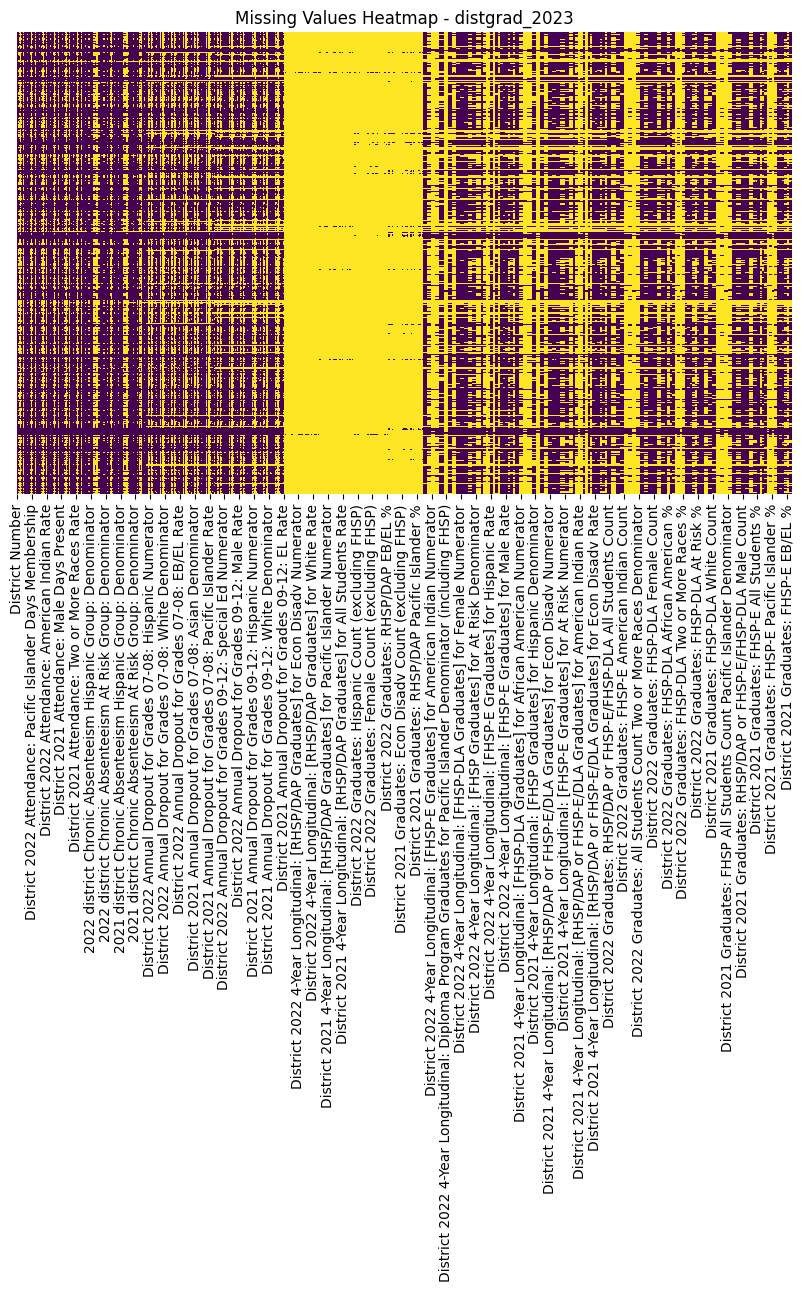

Heatmap for distperf1_2023


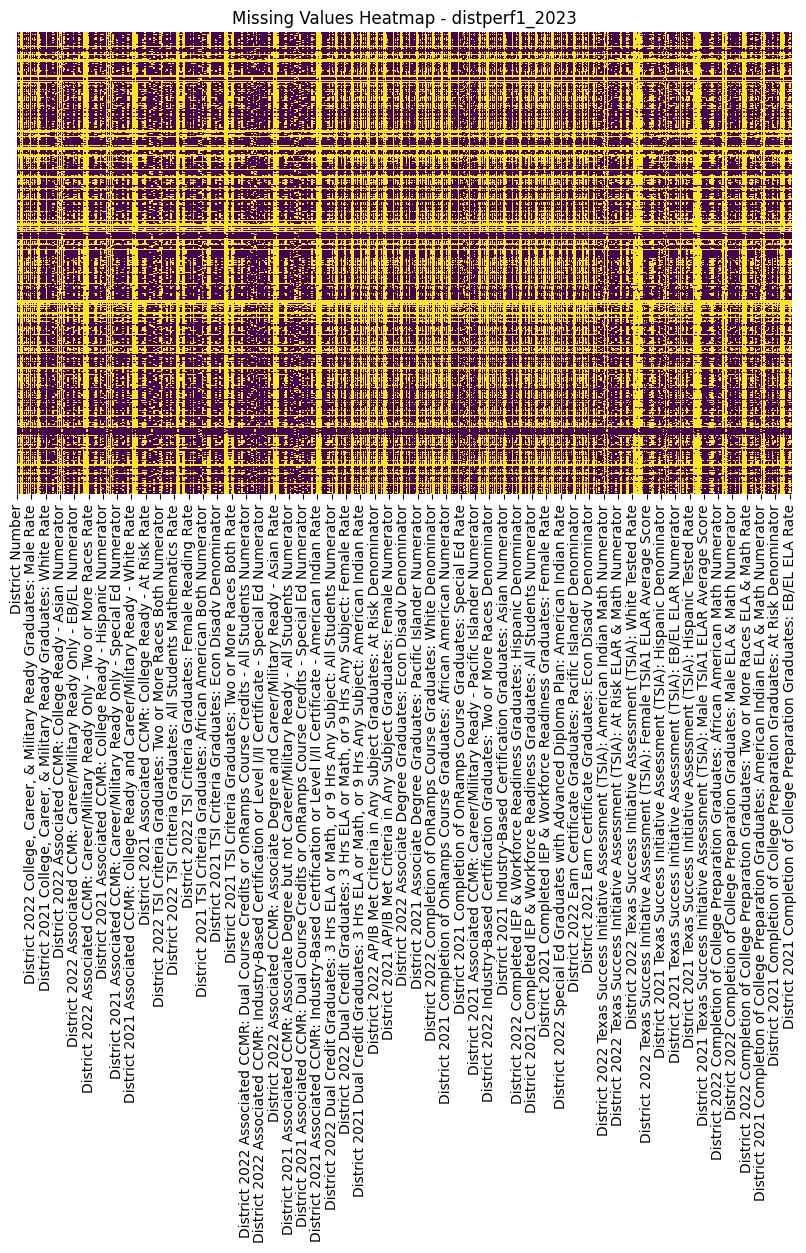

Heatmap for distprof_2023


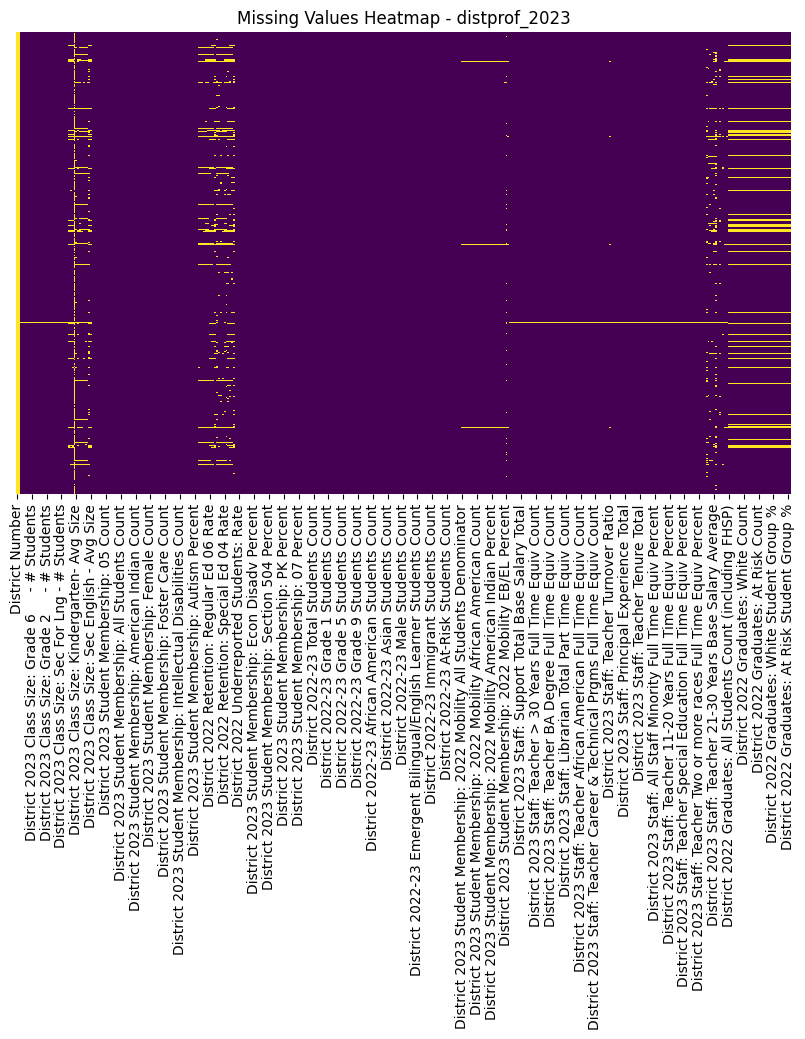

Heatmap for diststaar1_2023


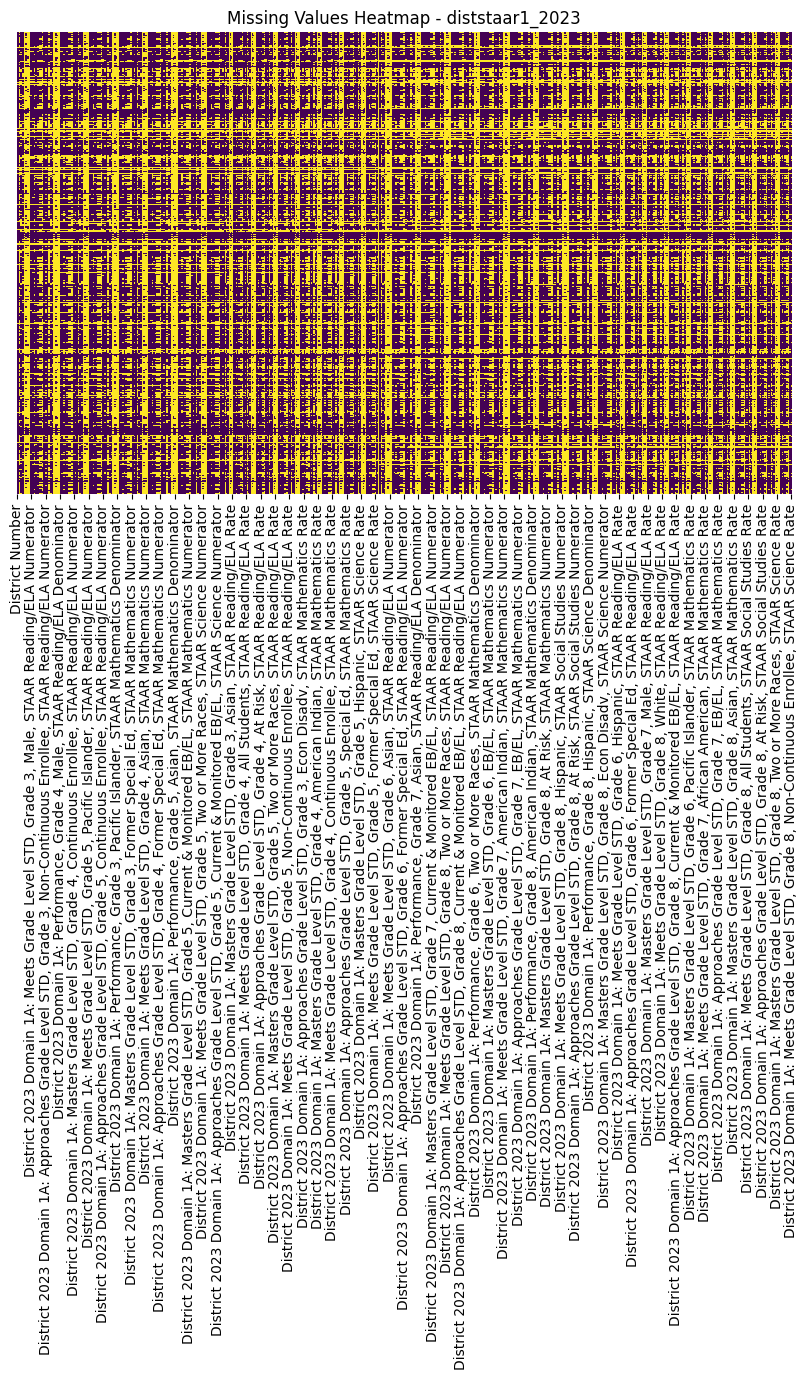

Heatmap for dref_2023


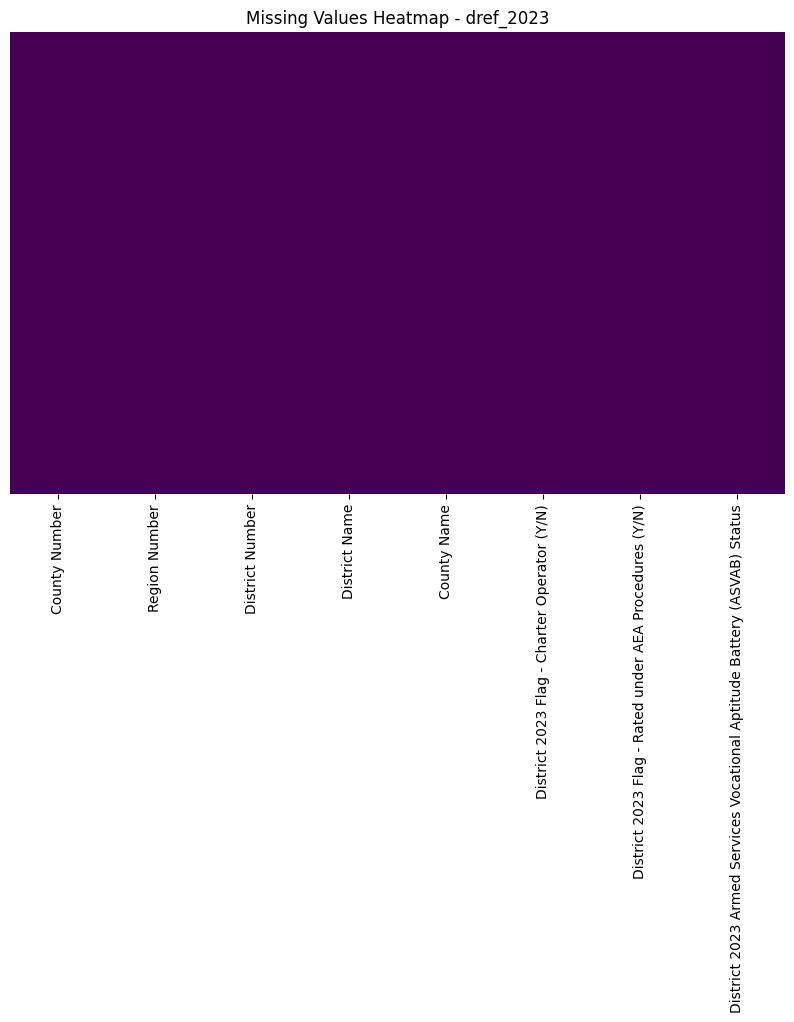

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_nas_heatmap(df_dict):
    """
    Plots a heatmap of NaN values for each DataFrame.
    
    Args:
        df_dict (dict): Dictionary of pandas DataFrames.
    """
    for key, df in df_dict.items():
        print(f"Heatmap for {key}")
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
        plt.title(f"Missing Values Heatmap - {key}")
        plt.show()


def visualize_na_bar(df_dict):
    """
    Plots a bar chart showing the percentage of NaN values per column.
    
    Args:
        df_dict (dict): Dictionary of pandas DataFrames.
    """
    for key, df in df_dict.items():
        print(f"Missing Values Bar Plot for {key}")
        na_percent = df.isnull().mean() * 100
        na_percent = na_percent[na_percent > 0]  # Only keep columns with missing values
        if not na_percent.empty:
            na_percent.plot(kind='bar', figsize=(12, 5), title=f"Missing Values Percentage - {key}")
            plt.ylabel("Percentage of Missing Values")
            plt.show()
        else:
            print(f"No missing values in {key}")

#visualize_na_bar(data_23_clean)
visualize_nas_heatmap(data_23_clean)

In [119]:
data_23_clean['distperf1_2023']

,District Number,"District 2022 College, Career, & Military Ready Graduates: All Students Numerator","District 2022 College, Career, & Military Ready Graduates: All Students Denominator","District 2022 College, Career, & Military Ready Graduates: African American Numerator","District 2022 College, Career, & Military Ready Graduates: African American Denominator","District 2022 College, Career, & Military Ready Graduates: Hispanic Numerator","District 2022 College, Career, & Military Ready Graduates: Hispanic Denominator","District 2022 College, Career, & Military Ready Graduates: White Numerator","District 2022 College, Career, & Military Ready Graduates: White Denominator","District 2022 College, Career, & Military Ready Graduates: American Indian Numerator",...,District 2021 Completion of College Preparation Graduates: Econ Disadv ELA & Math Rate,District 2021 Completion of College Preparation Graduates: Special Ed ELA Rate,District 2021 Completion of College Preparation Graduates: Special Ed Math Rate,District 2021 Completion of College Preparation Graduates: Special Ed ELA & Math Rate,District 2021 Completion of College Preparation Graduates: EB/EL ELA Rate,District 2021 Completion of College Preparation Graduates: EB/EL Math Rate,District 2021 Completion of College Preparation Graduates: EB/EL ELA & Math Rate,District 2021 Completion of College Preparation Graduates: At Risk ELA Rate,District 2021 Completion of College Preparation Graduates: At Risk Math Rate,District 2021 Completion of College Preparation Graduates: At Risk ELA & Math Rate
0,NaN,44.0,46.0,NaN,NaN,NaN,NaN,35.0,37.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.1,11.1,0.0
1,NaN,62.0,69.0,NaN,NaN,5.0,6.0,54.0,59.0,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,3.8,0.0
2,NaN,45.0,45.0,NaN,NaN,NaN,NaN,39.0,39.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,NaN,24.0,24.0,NaN,NaN,NaN,NaN,-3.0,-3.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,222.0,233.0,49.0,54.0,96.0,101.0,66.0,67.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,NaN,15.0,16.0,NaN,NaN,NaN,NaN,-3.0,-3.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1205,NaN,28.0,44.0,NaN,NaN,15.0,24.0,13.0,18.0,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,NaN,193.0,242.0,NaN,NaN,-3.0,-3.0,NaN,NaN,NaN,...,10.2,0.0,4.5,0.0,14.7,17.6,8.8,20.3,26.0,12.2
1207,NaN,64.0,104.0,NaN,NaN,64.0,104.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
